# Генератор отзывов

## Импорт библиотек

In [2]:
import wget

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import string
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import os
import shutil
from datasets import Dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    GPT2LMHeadModel, 
    GPT2TokenizerFast, 
    Trainer, 
    TrainingArguments, 
    DataCollatorForLanguageModeling
)
from random import randint

%matplotlib inline

## EDA

### Загрузка датасета

In [2]:
url = 'https://github.com/yandex/geo-reviews-dataset-2023/raw/refs/heads/master/geo-reviews-dataset-2023.tskv'
filename = wget.download(url)

### Преобразование в датафрейм

In [3]:
# Считаем при помощи pandas исходный файл с табуляцией в качестве разделителя, задав нужные нам имена колонок
df = pd.read_csv('geo-reviews-dataset-2023.tskv', sep='\t', header=None, names=['address', 'name_ru', 'rating', 'rubrics', 'text'])
columns = df.columns.to_list()
# Пройдем в цикле по колонкам и удалим из ячеек ключи
for column in columns:
    df[column] = df[column].replace(f'{column}=', '', regex=True)

In [4]:
# Посмотрим первые строки
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


### Базовый анализ датафрейма

Посмотрим основную информацию по нашему датафрейму

In [5]:
# Размер датафрейма
print(f'Размер датафрейма: {df.shape}')

Размер датафрейма: (500000, 5)


In [6]:
# Типы данных
print(df.dtypes)

address    object
name_ru    object
rating     object
rubrics    object
text       object
dtype: object


In [7]:
# Кол-во уникальных значений
df.nunique()

address    191925
name_ru    148461
rating        393
rubrics     32694
text       498918
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  500000 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     499030 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


Видим, что в колонке 'text' есть пропущенные значения. Поскольку данных у нас очень много, и целиком датасет мы все равно использовать не будем (так как дообучение моделей тогда растянется на несколько недель), просто удалим все строки, где есть пропущенные значения.

In [9]:
df = df.dropna(ignore_index=True)

In [10]:
# Проверим наличие дубликатов
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

np.int64(1)

In [11]:
df.loc[df.duplicated(keep=False), :]

,address,name_ru,rating,rubrics,text
123882,"Красноярск, Ястынская улица, 14",Спарта Маркет,5.,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."
123884,"Красноярск, Ястынская улица, 14",Спарта Маркет,5.,Автоакустика;Тонирование автостёкол;Плёнки арх...,"Хорошие консультанты, вежливые.\nВсе помогли ,..."


Действительно, у нас есть один дубликат

In [12]:
# Теперь обрежем точку после цифры в колонке 'rating' и приведем колонку к типу int64
df['rating'] = df['rating'].replace('\.', '', regex=True)
df['rating'] = pd.to_numeric(df['rating'])

Посмотрим, как в датасете распределены оценки

<Axes: xlabel='rating', ylabel='Count'>

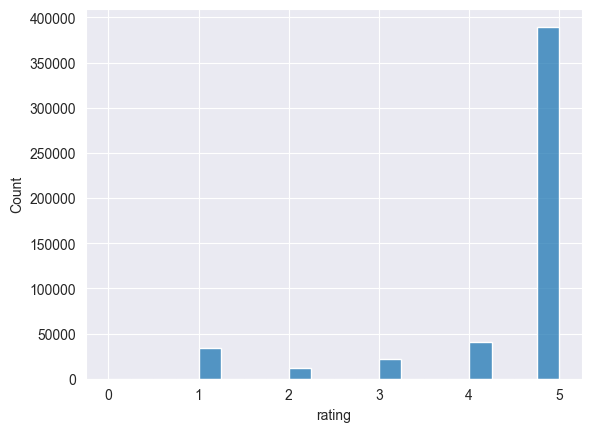

In [13]:
sns.histplot(df['rating'])

In [14]:
# Посмотрим, что из себя представляют отзывы на 0 баллов
df.query('rating == 0').head()

,address,name_ru,rating,rubrics,text
1906,"Республика Карелия, Суоярви, улица Шельшакова, 1",Гостиница Карелия,0,Гостиница,"Гостиница расположенна удобно, если отремонтир..."
2164,"Кемерово, улица Тухачевского, 12",Светофор,0,Магазин автозапчастей и автотоваров;Автоаксесс...,Это мой любимый магазин с запчастями. Можно вс...
3583,"Краснодарский край, Анапа, улица Пушкина, 30",Кубань,0,Санаторий,"Нет растительного масла для салата, нет зубочи..."
3614,"Краснодарский край, Туапсинский район, Новомих...",Счастливый Хотей,0,Гостиница,"Все довольны, и взрослые и дети.\nВкусная еда...."
6384,"Ленинградская область, Выборг, улица Мира, 8А",Атриум,0,Торговый центр,"Большой выбор, очень грамотно и удобно разложе..."


Как мы видим, отзывы на 5 звезд люди оставляют значительно чаще, чем с другим рейтингом. Наверное, в дальнейшем нам стоит сбалансировать классы для обучающей выборки.
Так же есть шум в виде отзывов на 0 баллов (хотя если посмотреть на текст таких отзывов - он в основном положительный).

Добавим в наш датафрейм колонку, в которой будет указана длина отзыва и проанализируем полученный результат.

In [15]:
df['review_length'] = df['text'].str.len()

In [16]:
df['review_length'].describe()

count    499030.000000
mean        303.232533
std         292.609661
min           2.000000
25%         145.000000
50%         215.000000
75%         365.000000
max       20162.000000
Name: review_length, dtype: float64

<Axes: xlabel='review_length', ylabel='Count'>

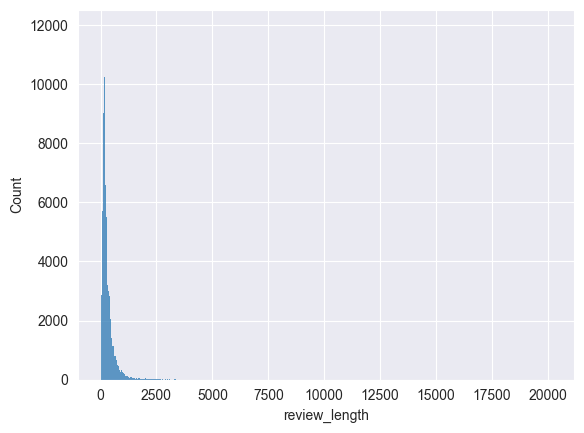

In [17]:
sns.histplot(df['review_length'])

<Axes: ylabel='review_length'>

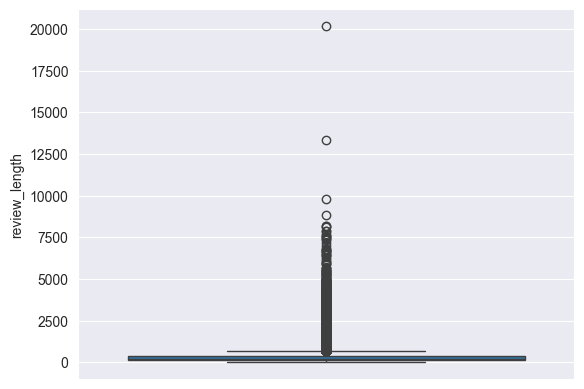

In [18]:
sns.boxplot(df['review_length'])

In [19]:
# Посмотрим, как выглядят отзывы более 10000 символов
df.query('review_length > 10000')['text'].values

array(['Que si, que no...\\nМногажды бывал в этом замечательном отеле, и с каждым разом всё больше и больше эта песня про тупящего влюблённого, являющаяся гимном отеля, всё точнее и точнее описывает качество отдыха. Вообще, этот гимн противоречиям максимально отражает происходящее с Вами на отдыхе в Ялта Интурист.\\nНачинается знакомство с особенностями сервиса со службы размещения (это те, кого называют ресепшн). Приветливость сотрудников на стойке регистрации можно выделить отдельно, Вас всегда встретят с улыбкой, всё расскажут и ответят на Ваши вопросы при заселении, но на чемпионате мира по созданию очередей, они без особого труда возьмут второе место (первое – без шансов конкурентам у транспортной безопасности терминала Аэроэкспресс в Шереметьево). Специальный удобный трансфер быстро перемещает десятки гостей из аэропорта и вокзала в очередь на заселение, где на 6 стойках регистрации работают всего один или два сотрудника. Господа, это, же, элементарно: на время прибытия трансферо

In [20]:
# И также как выглядят отзывы менее 10 символов
df.query('review_length < 10')['text'].values

array(['Круто', 'Круто', 'кайф\\n', 'Все круто', 'Отлично ', 'Отлично!',
       'Прилично ', 'Лучшие!', 'Клас!', 'Класс', 'Хорошо ', 'Удобно',
       'Супер', 'Не плохо ', 'Нормально', 'Спасибо!', 'Отлично',
       'Спасибо', 'Норм', 'Стандарт.', 'Чисто!', 'Все отл', 'Удобно',
       'Хорошо', '10 из 10', 'Ок', 'Вкусно', 'Супер', 'Норм', 'Вкусно',
       'Красавцы', 'Не вкусно', 'Все норм.', 'Профи!', 'Отлично.',
       'Круть', 'Чисто', 'Отлично.', 'Хорошо ', 'Бомба', 'Всё супер',
       'топ топ', 'Норм', 'Вполне!', 'Всё чëтко', 'Вкусно', 'Класс! '],
      dtype=object)

Как видим, у нас присутствуют выбросы (как слишком маленькая длина отзыва, так и слишком большая).
В обоих вариантах отзывы лишены здравого смысла.
В дальнейшем нужно будет удалить эти выбросы из датафрейма.

In [21]:
df_cor = df[['rating', 'review_length']]
df_cor

,rating,review_length
0,3,537
1,5,158
2,1,485
3,4,142
4,5,373
...,...,...
499025,5,76
499026,4,295
499027,4,325
499028,5,502


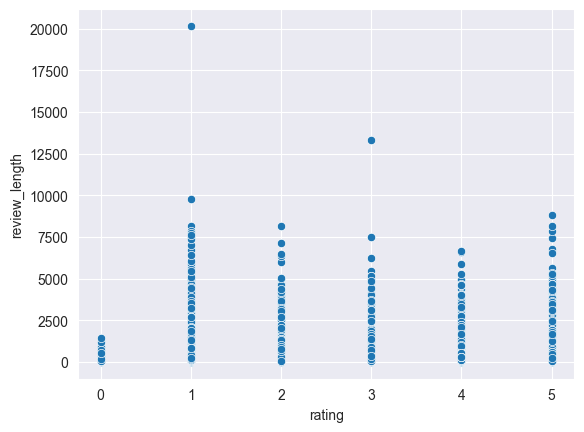

In [22]:
# Диаграмма рассеяния
sns.scatterplot(x='rating', y='review_length', data=df_cor)
plt.show()

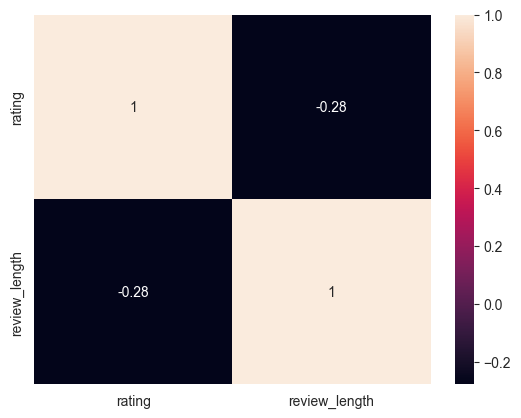

In [23]:
# Корреляционная матрица
corr_matrix = df_cor.corr()

# Визуализируем корреляционную матрицу
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [24]:
# Сохраним наш датафрейм в tsv файл для дальнейшей работы
df.to_csv('geo-reviews-dataset-2023.tsv', sep='\t', index=False)

### Расчет частотности слов

Теперь посчитаем количество уникальных слов в отзывах

In [25]:
# Соберем все тексты отзывов в одну строку
words_list_list = df['text'].to_list()
words_str = ' '.join(str(string) for string in words_list_list)

In [26]:
# Удалим из строки все спец.символы
def remove_chars_from_text(text, chars):
    return "".join([char for char in text if char not in chars])

spec_chars = string.punctuation + '\n\xa0«»\t—…n'

text = remove_chars_from_text(words_str, spec_chars)
text = remove_chars_from_text(text, string.digits)

# Приведем все слова к нижнему регистру
text = text.lower()

In [27]:
# Токенизируем текст
nltk.download('punkt_tab')
text_tokens = word_tokenize(text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/johnneon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [28]:
# Посмотрим статистику по неочищенным словам


# Для применения инструментов частотного анализа библиотеки NLTK необходимо список токенов преобразовать к классу Text
text = nltk.Text(text_tokens)
fdist = FreqDist(text)

print('Статистика по неочищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по неочищенным словам

Всего слов: 21306636

Уникальных слов: 742932

Топ-10 слов по частоте: 
и:  874480
в:  604858
не:  400240
на:  389339
очень:  298972
с:  289708
что:  205890
все:  170685
но:  141965
по:  137147


In [29]:
# Теперь очистим слова от служебных частей речи
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
custom_stopwords = ['очень', 'это', 'всё', 'всем', 'еще', 'ещё']
stopwords_united = russian_stopwords + custom_stopwords
text_with_no_stopwords = [word for word in text if word not in stopwords_united]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnneon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# И посмотрим статистику по очищенным словам

fdist = FreqDist(text_with_no_stopwords)

print('Статистика по очищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по очищенным словам

Всего слов: 14173971

Уникальных слов: 742776

Топ-10 слов по частоте: 
персонал:  82456
место:  74975
спасибо:  73776
рекомендую:  60037
просто:  49583
магазин:  46361
хороший:  43166
цены:  42268
вкусно:  40279
быстро:  40030


<Axes: xlabel='Samples', ylabel='Counts'>

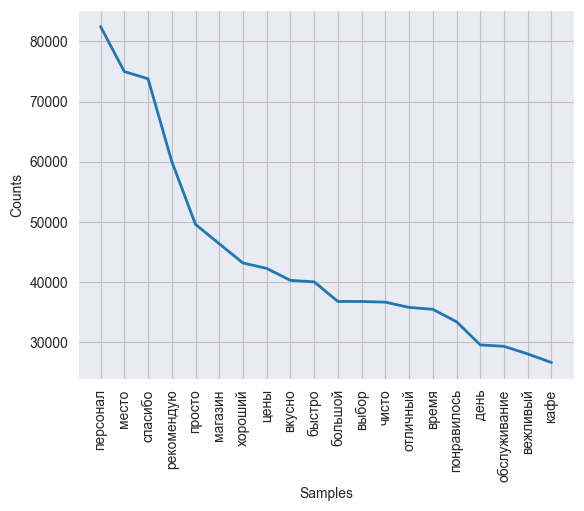

In [31]:
# Чтобы добавить сюда что-нибудь красивое - нарисуем график частоты топ-20 очищенных слов

fdist.plot(20,cumulative=False)

### Облако слов

Составим облако очищенных слов по частоте употребления

In [32]:
wordcloud = WordCloud(width=1200, height=600).generate_from_frequencies(fdist)

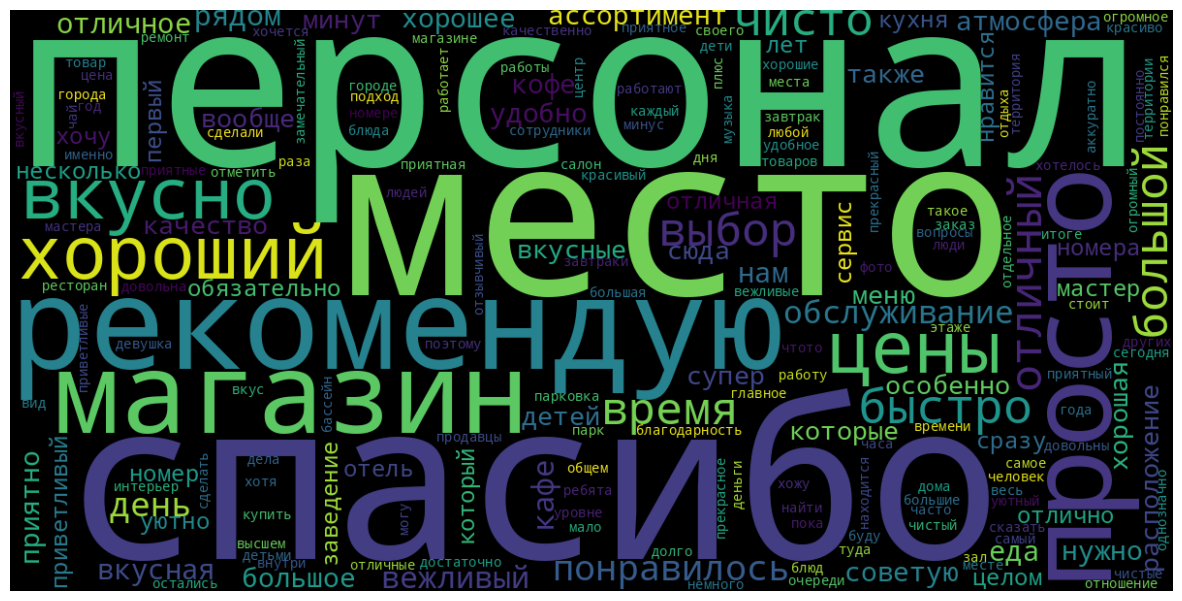

In [33]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


Выводы по этапу EDA:
1. Нужно удалить строки с пропущенными значениями
2. Нужно удалить дубликаты
3. Нужно удалить строки с отзывами на 0 баллов
4. Нужно удалить строки со слишком большой и слишком маленькой длиной текста отзыва
5. Возможно, для дальнейшего обучения моделей стоит сбалансировать классы отзывов по значениям рейтига 

## Предобработка

In [34]:
# Исходный датафрейм
df = pd.read_csv('geo-reviews-dataset-2023.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499030 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        499030 non-null  object
 1   name_ru        499030 non-null  object
 2   rating         499030 non-null  int64 
 3   rubrics        499030 non-null  object
 4   text           499030 non-null  object
 5   review_length  499030 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


Строки с пропущенными значениями и дубликаты были удалены на прошлых этапах

Нормализация текстов (удаление спецсимволов, приведение к нижнему регистру):

In [35]:
def normalize_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление специальных символов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)
    
    return text

# Применяем функцию ко всем отзывам
df['text'] = df['text'].apply(normalize_text)


Обработка категорий

In [36]:
# Посмотрим сколько уникальных значений по столбцам
df.nunique()

address          191639
name_ru          148456
rating                6
rubrics           31724
text             498805
review_length      3004
dtype: int64

Большое количество уникальных значений по категориальным признакам, считаю применение onehot кодирования нерентабельным

Группировка категорий уникальные значения которых встречаются реже всего

In [37]:
# Cгруппировать все категории, которые встречаются менее чем в 0.00021% случаев
category_counts = df['rubrics'].value_counts(normalize=True)
rare_categories = category_counts[category_counts < 0.0000021].index

rare_categories

Index(['Офис интернет-магазина;Зоомагазин;Доставка продуктов',
       'Спортивный, тренажёрный зал;Спортивная база;Аренда площадок для культурно-массовых мероприятий',
       'Магазин мяса, колбас;Продукты глубокой заморозки;Молочный магазин;Магазин кулинарии;Магазин сыров',
       'Системы водоснабжения и канализации;Отопительное оборудование и системы;Монтаж и обслуживание систем водоснабжения и канализации',
       'Копировальный центр;Печати и штампы;Магазин канцтоваров;Типография',
       'Диагностический центр;Поликлиника для взрослых;Медсанчасть',
       'Банкетный зал;Развлекательный центр;Кейтеринг',
       'Достопримечательность;Магазин подарков и сувениров',
       'Ресторан;Кафе;Зимние сады, веранды, террасы',
       'Курьерские услуги;Грузовые авиаперевозки;Почтовые услуги',
       ...
       'Автомойка;Кофейня;Кофе с собой',
       'Салон оптики;Коррекция зрения;Медицинские изделия и расходные материалы;Контактные линзы',
       'Магазин мебели;Оптовый магазин;Корпусная м

Есть категории которые встречаются редко в датафрейме, но по смыслу разные и могут пригодиться для генерации отзывов. Считаю, что не нужно группировать их в одну категорию.

Удаляем строки с рейтингом 0

In [38]:
# Убираем строки с рейтингом 0
df = df.query("rating > 0")

# Выводим кол-во уникальных значений по колонкам для проверки результата
df.nunique()

address          191595
name_ru          148421
rating                5
rubrics           31715
text             498606
review_length      3004
dtype: int64

<Axes: xlabel='rating', ylabel='Count'>

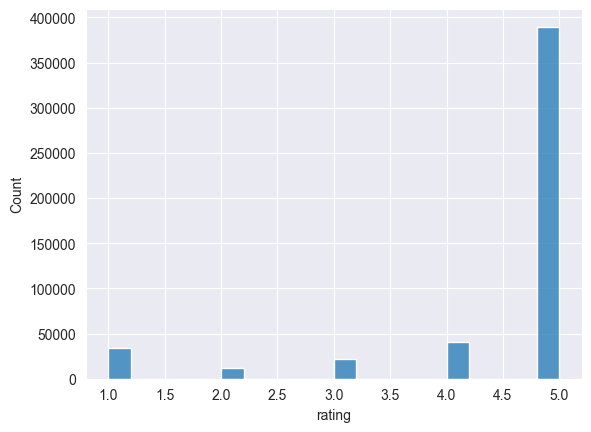

In [39]:
# Выведем график распределения для визуализации
sns.histplot(df['rating'])

In [40]:
# Проверим сколько строк удалилось после преобразований
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498830 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498830 non-null  object
 1   name_ru        498830 non-null  object
 2   rating         498830 non-null  int64 
 3   rubrics        498830 non-null  object
 4   text           498830 non-null  object
 5   review_length  498830 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


Удалилось 200 строк

Удаляем строки со слишком большой и слишком маленькой длиной текста отзыва

In [41]:
# Удаление отзывов с длиной более 4000 слов
df = df.query('review_length < 4000')

# Удаление отзывов с длиной менее 10 слов
df = df.query('review_length > 10')

In [42]:
# Проверяем результат
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498639 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


Удалилось еще 191 строка

<Axes: xlabel='review_length', ylabel='Count'>

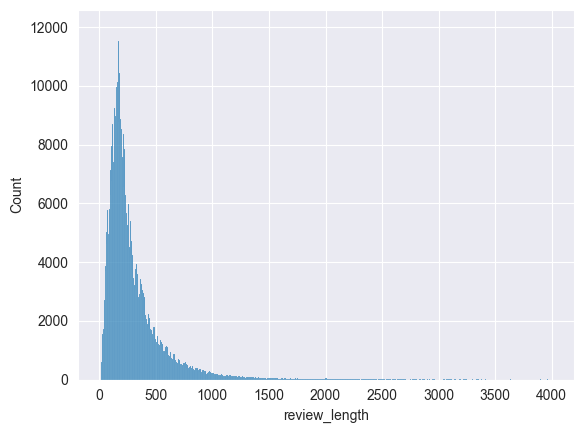

In [43]:
# Выведем график распределения по длине отзывов, для визуализации результата
sns.histplot(df['review_length'])

In [44]:
# Проверим балансировку классов по рейтингу
print(Counter(df['rating']))

Counter({5: 389606, 4: 41096, 1: 34246, 3: 21634, 2: 12057})


Как уже отмечалось выше, присутствует дисбалансировка по рейтингу

Заменяем символы переноса строки (\\n) на пробелы:

In [45]:
df['text'] = df['text'].str.replace('\\n', ' ')

# И еще заменим откуда-то взявшиеся вместо пробелов буквы "n"
df['text'] = df['text'].str.replace('n', ' ')

В итоге получаем очищенные датафрейм df для дальнейшей работы

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498639 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


In [47]:
# Сохраним предобработанный датасет в tsv файл
df.to_csv('dataset_preprocessed.tsv', sep='\t', index=False)

### После проблем с дообучением модели было принято решение сбалансировать классы оценок и обрезать датасет до 15000 строк. 

Конечно было бы классно сделать сюда кластеризацию, и сбалансировать места по категориям, но времени у нас на это нет (может, доделаем позже). А пока что сделаем то, что точно успеем.

In [48]:
# Подгрузим файл с прошлого шага
df = pd.read_csv('dataset_preprocessed.tsv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498639 entries, 0 to 498638
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498639 non-null  object
 1   name_ru        498639 non-null  object
 2   rating         498639 non-null  int64 
 3   rubrics        498639 non-null  object
 4   text           498639 non-null  object
 5   review_length  498639 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


Пока что у нас в датасете 498639 строк.

In [49]:
# Создадим список, в который отправим категории, которые встречаются в датасете не менее 200 раз
frequent_rubrics = df.rubrics.value_counts().reset_index(name="count").query("count >= 200")['rubrics'].to_list()

# Заполним редкие рубрики NaN (если их нет в списке частх рубрик)
df['rubrics'] = df['rubrics'].apply(lambda rubric: rubric if rubric in frequent_rubrics else np.nan)

# Удалим NaN
df = df.dropna(ignore_index=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319099 entries, 0 to 319098
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        319099 non-null  object
 1   name_ru        319099 non-null  object
 2   rating         319099 non-null  int64 
 3   rubrics        319099 non-null  object
 4   text           319099 non-null  object
 5   review_length  319099 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.6+ MB


Осталось 319099 строк.

In [51]:
# На всякий случай проверим, осталось ли нужное нам количество строк каждого класса
print(Counter(df['rating']))

Counter({5: 243849, 4: 30943, 1: 19993, 3: 15961, 2: 8353})


Так как нам нужно 15000 строк, а классов оценки у нас 5, то просто наберем по 3000 строк каждого класса.

In [52]:
# Функция для конкатенации датафреймов по рейтингу
def balance_rating(df, len_for_each_rating=3000):
    df_dict = {}
    for rating in range(1, df.rating.nunique()+1):
        # Датафреймы с нужным рейтингом и нужной длины соберем в словарь
        df_dict["df_rating" + str(rating)] = df.query(f'rating == {rating}')[:len_for_each_rating]
    # Сконкатенируем датафреймы из словаря
    df_cropped = pd.concat(df_dict.values(), ignore_index=True)
    return df_cropped


In [53]:
df = balance_rating(df, 3000)

Наглядно посмотрим, что все получилось как надо

<Axes: xlabel='rating', ylabel='Count'>

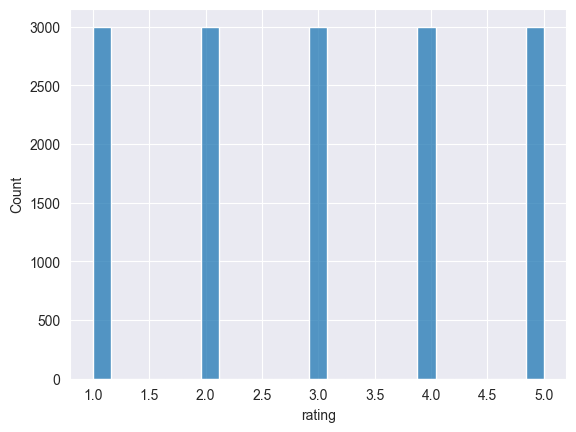

In [54]:
sns.histplot(df['rating'])

In [55]:
# Сохраним обрезанный датасет для дальнейшего удобного использования
df.to_csv('dataset_cropped.tsv', sep='\t', index=False)

## Подготовка данных для подачи на обучение

Для начала структурируем данные, объединим rubrics, rating и text в единый текстовый формат:

Важный момент с форматированными текстами, это нужно для того что бы помочь структурировать данные и облегчить задачу модели. Так же это нужно для улучшения генерации, так после обучения это будет помогать задавать контекст, и при подаче данных в виде например "Category: Restaurants. Rating: 5. Review:" модель сгенерирует отзыв, соответствующий ресторану с высоким рейтингом.

Так же подобная структура упростит расширение, так как мы можем добавлять сюда еще поля если захотим подавать больше параметров на обучения.

In [56]:
def format_review(row):
    return f"Category: {row['rubrics']}. Rating: {row['rating']}. Review: {row['text']}"

df['formatted_text'] = df.apply(format_review, axis=1)

Далее токенизация.

Тут нам нужно перевести данные в токены, с использованием предобученного токенизатора (осторожно, процесс не быстрый, у меня на локалке занимает от 5 до 15мин.):

In [57]:
# Загрузка токенизатора GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

tokenizer.pad_token = tokenizer.eos_token

# Токенизация данных
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# Пример применения
df['tokenized'] = df['formatted_text'].apply(tokenize_function)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

С помощью datasets из Hugging Face создадим датасет для обучения:

In [58]:
dataset = Dataset.from_pandas(df[['formatted_text']])

# Токенизация всех текстов
def tokenize_data(batch):
    return tokenizer(batch['formatted_text'], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_data, batched=True)


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [59]:
# Разделение на train/test
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

Далее подготовим данные для обработки данных при обучении:

In [60]:
# Создание collator для задачи языкового моделирования
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # GPT-2 не использует маскирование
)

`DataCollatorForLanguageModeling` - инструмент из библиотеки Hugging Face, который динамически обрабатывает батчи данных для задач NLP. В данном случае используется для подготовки токенизированных данных к обучению GPT-2, если перечислить что он делает:

1. Формирует батчи
2. Добавлеет специальне токены
3. Упрощяет обработку

В итоге на этапе подготовки данных для обучения мы получили:

1. `train_dataset` и `test_dataset` - датасеты для обучения и валдиации
2. `data_collator` - "подборщик данных", инструмент для обучения
3. `tokenizer` - обученный токенизатор

## Обучение

Дальнейшее обучение было выполнялось в отдельных блакнотах, по причинам сложности перезапуска этого (длительности обработки данных), а так же совместимости (разные оси + использование Google Colab).

Небольшой отчет по обучению:

Первым этапом взялись обучать стандартную GPT-2 (блакнот с обучением которой находится в [GPT2_train.ipynb](./GPT2_train.ipynb)). Результаты разочаровывали, как вела себя модель можно посмотреть в [скринкасте](./docs/screencast_gpt_2.md). Помимо всего скорость обучения оставляла желать лучшего, модель обучалась 14 с половиной часов (локально на 3060ti).

Далее было принято решение искать что-то более подходящее, так как не имело смысла заниматься улучшением и сверкой метрик с настолько слабыми результатами, и долгим обучением.

Мы нашли модели GPT-2 предобученные на ru данных, и решили использовать их. После ресерча подходящих моделей, наткнулись на идеальный для нас вариант - `ai-forever/rugpt3small_based_on_gpt2` - легковесная модель предобученная на ru данных. Это гарантировало получение более приемлемых результатов, с более быстрым рабочим процессом.

В итоге после подбора оптимальных параметров для обучения, учитывая баланс времени/качества, мы смогли обучить модель за 24 минуты, которая давала гораздо более чувствительные и логические результаты, скринкаст с ними можно посмотреть [тут](./docs/screencast_gpt_2_ru.md), а процесс обучения - [GPT2_RU_train.ipynb](./GPT2_RU_train.ipynb). 

## Совершенствование

## Анализ

Загружаем предобученную модель

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("./model/train-model-1")
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path="./model/train-model-1",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
# Перемещение модели на GPU или CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

В качестве метрики выберем BLUE

In [ ]:

# Загружаем реализации метрики из библиотеки nltk
from nltk.translate.bleu_score import sentence_bleu

Посчитаем оценку 5 раз

In [ ]:
for n in range(0,5):   
   numb = randint(0, 498639)
   reference =  df['text'].loc[numb]
   rating =  df['rating'].loc[numb]
   rubrics = df['rubrics'].loc[numb]
   input_text = f"rubrics = {rubrics}\nrating = {rating}\nReview:"
   inputs = tokenizer(input_text, return_tensors="pt").to(device)
   output = model.generate(
      **inputs,
      max_length=60,
      temperature=0.8,
      no_repeat_ngram_size=2,
      do_sample=True,
      num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,  
      pad_token_id=tokenizer.eos_token_id,  
      early_stopping=True,  
      top_k=30,         
      top_p=0.8,        
   )
   print('Оценка номер ', n+1)
   print('Rating=', rating, 'Rubrics=', rubrics)
   for i, sequence in enumerate(output):
      print(reference)
      generated_text = tokenizer.decode(sequence, skip_special_tokens=True)
      candidate = re.findall(r'(?<=Review: ).*', generated_text)[0]
      print(candidate)
      score = sentence_bleu(reference, candidate)
      print(score)

Оценка номер  1
Rating= 5 Rubrics= Супермаркет;Гипермаркет
я не ошибусь если назову этот торговый центр самым популярным в городе многообразные бутики зоны отдыха детские площадки ну и конечно маяк все для всех и продукты и текстиль и игрушки качество конечно сомнительное но цены покупают
магазин расположен в центре города рядом с метро  удобно расположен магазином  есть все необходимое для приготовления пищи и товаров  магазин находится на первом этаже жилого дома рядом расположен продуктовый магазин и продуктовая гипермаркет
1.0529201163813138e-231
Оценка номер  2
Rating= 5 Rubrics= Жанровая скульптура
замечательное место памятник который был открыт в 2015 году в год 70летая победы в великой отечественной войне является единственным в своем роде
очень нравится идея создания этого шедевра но на мой взгляд она не очень удачная и для него нужен не только объем но и наличие какого то дополнительного пространства для создания чего то очень большого и объемного  что не
1.0347661519348002e-

Как видим - оценка стремится к 0. Но это и неудивительно, исходные данные для генерации отзыва не велики, а вот разнообразие возможных отзывов огромно.
Попробуем выполнить оценку Meteor.

In [ ]:
# Загружаем реализации метрики из библиотеки nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vald\AppData\Roaming\nltk_data...


True

Модифицируем цикл оценки и снова расчитам 5 оценок

In [ ]:
for n in range(0,5):   
    numb = randint(0, 498639)
    reference =  df['text'].loc[numb]
    rating =  df['rating'].loc[numb]
    rubrics = df['rubrics'].loc[numb]
    input_text = f"rubrics = {rubrics}\nrating = {rating}\nReview:"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        max_length=60,
        temperature=0.8,
        no_repeat_ngram_size=2,
        do_sample=True,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,  
        pad_token_id=tokenizer.eos_token_id,  
        early_stopping=True,  
        top_k=30,         
        top_p=0.8,        
    )
    print('Оценка номер ', n+1)
    print('Rating=', rating, 'Rubrics=', rubrics)
    for i, sequence in enumerate(output):
        print(reference)
        generated_text = tokenizer.decode(sequence, skip_special_tokens=True)
        candidate = re.findall(r'(?<=Review:).*', generated_text)[0]
        print(candidate)
        ref_token= word_tokenize(reference)
        cand_token= word_tokenize(candidate) 
        score = meteor_score([ref_token], cand_token)
        print(f"METEOR Score: {score:.4f}")

Оценка номер  1
Rating= 3 Rubrics= Пекарня;Быстрое питание;Кондитерская
наименее вкусная шаурма на районах никая просто перейдите через лосиноостровский мост и сразу рядом с часовней возьмите небо и земля
 заказала сегодня пиццу с креветками и крексами в качестве закуски и получила чек на скидку в размере 590 рублей за заказ с доставкой в
METEOR Score: 0.0980
Оценка номер  2
Rating= 5 Rubrics= Аптека
отличная аптека хорошее обслуживаниебольшой ассортимент лекарств
 я в восторге от этой аптеки  спасибо за то что вы есть всегда и всегда  я всегда с большим удовольствием покупаю лекарства в аптеке а не в магазине в частности в этом магазине всегда чисто и чисто  а
METEOR Score: 0.0000
Оценка номер  3
Rating= 5 Rubrics= Ресторан;Доставка еды и обедов
очень красиво очень атмосферно  ну не являясь любителем данной кухни могу сказать следующее   на вкус кухня была хороша конечно ингредиенты в салатах  экзотичны но я так понимаю на любителя было вкусно свеже горячие блюда были вкусные  в общем

Как видим, оценка Meteor так же не высока, что объясняется большим количеством возможных вариантов генерации при небольшом количестве исходных вариантов.

### Вывод

BLUE (best linear unbiased estimate) — это «наилучшая линейная несмещённая оценка». 

Другими словами, это оценка с наименьшей дисперсией в классе всех линейных несмещённых оценок. она показывает, как сильно оцениваемый фрагмент отличается от референсного. Изначально эта метрика предназначена для оценки точности перевода моделью, путём сравнения текста сгенерированного превода и эталонного перевода исходного текста человеком.

METEOR (Metric for Evaluation of Translation with Explicit ORdering (2004)) — метрика для оценки качества машинного перевода. Метрика базируется на использовании n-грамм и ориентирована на использование статистической и точной оценки исходного текста. В отличие от метрики BLEU[англ.], данная метрика использует функции сопоставления синонимов вместе с точным соответствием слов. Метрика была разработана, чтобы решить проблемы, которые были найдены в более популярной метрике BLEU, а также создать хорошую корреляцию с оценкой экспертов на уровне словосочетаний или предложений.

Как видим, обе метрики изначально нацелены на сравнение сгенерированного и эталонного текста. при этом предполагается, что число трактовок изначально не велико (В метрике BLUE требуется точное совпадение, а METEOR учитывает наличие синонимов и различныхъ словоформ).
Но в случае создания вольного текста данные метрики подходят слабо, так как один и тот же тип организции с одной оцценкой мы можем описать довольно большим количестом вариантов.
Поэтом наиболее правильным будет использовть экспертный анализ и самостоятельно определить на сколько естественно и органично смотрится отзыв.

Для нашей модели можно отметить, что зачастую отзывы выглядят как связные предложения подходящине для запрашиваемых организаций с соответствующими рейтингами. Однако не редко можно встретить и слобосвязные предложения. Это можно объяснить выбором (в связи с техническими ограничениями) довольно слабой изначально исходной модели.

Для улучшения результатов предлагается дальнейшее дообучение модели, или замена модели на более сильную с её обучением.


## Итог

Итогом разработки стало клиент-серверное приложение, где пользоваатель взаимодействует с интерфейсом оболочки пользователя, реализованной на streamlit, а непосредственно генерация происходит в модуле реализованном на на FastAPI.